In [157]:
import torch
import torch.tensor as tensor
import gpytorch
import torch.optim as optim
import torch.nn as nn
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
import numpy as np
from pprint import pprint
import warnings
from IPython.core import debugger
import time
import ax
from ax.api import ParameterType, RangeParameter, SearchSpace
from ax.api import modelbridge
from botorch.utils.sampling import SobolEngine, NormalQMCEngine
from botorch.utils.sampling import draw_sobol_normal_samples

# Define a GP and specify hyperparameters

In [163]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

train_x = None
train_y = None
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)
theta = model.state_dict()
print('Default hyperparameters (before softplus transformation):')
pprint(theta)
softplus_inv = lambda a: np.log(np.exp(a) - 1)
raw_noise_var = softplus_inv(0.0001)
print(nn.functional.softplus(tensor([raw_noise_var])))
raw_length_scale = softplus_inv(.5)
print('Set noise level and length scale:')
theta['likelihood.noise_covar.raw_noise'].data.fill_(raw_noise_var)
theta['covar_module.base_kernel.raw_lengthscale'].data.fill_(raw_length_scale)
pprint(theta)
print(model.covar_module.base_kernel.lengthscale.item())
print(model.likelihood.noise.item())


Default hyperparameters (before softplus transformation):
OrderedDict([('likelihood.noise_covar.raw_noise', tensor([[0.]])),
             ('mean_module.constant', tensor([[0.]])),
             ('covar_module.raw_outputscale', tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[0.]]))])
tensor([0.0001])
Set noise level and length scale:
OrderedDict([('likelihood.noise_covar.raw_noise', tensor([[-9.2103]])),
             ('mean_module.constant', tensor([[0.]])),
             ('covar_module.raw_outputscale', tensor(0.)),
             ('covar_module.base_kernel.raw_lengthscale', tensor([[-0.4328]]))])
0.5
0.00020000003860332072


# Draw a sample from the prior GP and posterior GP

tensor(0.3640)
tensor([-1.,  1.])
tensor([0.3640, 1.4767])


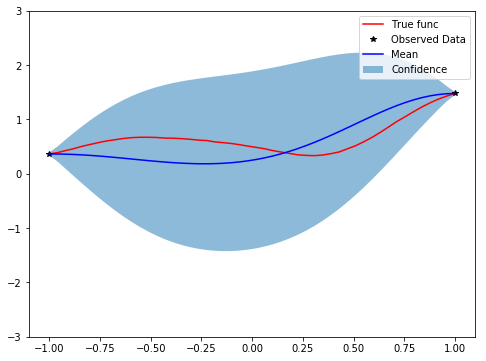

In [164]:
model.eval()
bound = 1
n = 50
x = torch.linspace(-bound,bound,n)

y_prior = model(x)
torch.manual_seed(13)
y = y_prior.sample()
print(y[0])

train_idx = [np.round(n/3), np.round(n*2/3)];
train_idx = [0, n-1]
train_x = x[train_idx]
train_y = y[train_idx]
print(train_x)
print(train_y)
model.set_train_data(train_x, train_y, strict=False)
y_post = model(x)

with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    # Get upper and lower confidence bounds
    lower, upper = y_post.confidence_region()
    # Plot training data as black stars
    ax.plot(x.numpy(), y.numpy(), 'r')
    ax.plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(x.numpy(), y_post.mean.detach().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['True func', 'Observed Data', 'Mean', 'Confidence'])

# Define EI for minimization problem
EI(x) = sig * (z * Phi(z) +N(z)), where z = (y_best - mu(x)) / sig(x)

In [165]:

def check_bounds(x, bounds):
    """
    check if x falls into the bounded region
    x: 1*d
    bounds: d*2
    """
    d = bounds.shape[0]
    x = x.reshape(-1,1)
    assert x.shape[0] == d
    if (np.any(x < bounds[:,0]) or
        np.any(x > bounds[:,1])):
        return False
    return True 

In [166]:
def expected_improvement(mu, sig, y_best):
    z = (y_best - mu) / sig
    standard_normal = torch.distributions.normal.Normal(loc=0, scale=1)
    # g.cdf(z) * z + torch.exp(g.log_prob(z))
    ei = sig * (z * standard_normal.cdf(z) + torch.exp(standard_normal.log_prob(z)))
    return ei

def expected_improvement_wrapper(x, gp_model, y_best):
    y_dist = gp_model(x)
    sig = torch.sqrt(y_dist.variance)
    ei_values = expected_improvement(y_dist.mean, sig, y_best)
    return ei_values


def multi_start_optim(func, 
                      dim=None,
                      bounds=None,
                      num_iters=100, 
                      x_inits=None, 
                      learning_rate=0.01,  
                      num_restarts=1, 
                      tolerance=1e-8,
                      print_every = 10):
    # optimize ei continuously
    if x_inits is not None:
        num_restarts = len(x_inits)
    else:
        d = bounds.shape[0]
        sobol_engine = SobolEngine(d, scramble=True, seed=0)
        x_inits = np.array(sobol_engine.draw(num_restarts), dtype=np.float32)
    
    x_star = tensor(x_inits[0])
    min_loss = 0.
    for restart in range(num_restarts):   
        x0 = tensor(x_inits[restart], requires_grad=True)
        print('Initialized at: ', x0)
        optimizer = optim.Adam([x0], lr=learning_rate)
        for i in range(num_iters):
            optimizer.zero_grad()
            loss = func(x0)
            loss.backward()

            def closure():
                optimizer.zero_grad()
                loss = func(x0)
                loss.backward()
                return loss
            optimizer.step(closure)
            if not check_bounds(x0.detach().numpy(), bounds):
                break
            
            if i % print_every == 0:
                #info = (f'iter {i:3}, EI value: {-loss.item():10.3} ' 
                #        f'x: {x0.item(): -10.3} x.grad: {x0.grad.item(): 10.3}')
                info = 'iter %3d: EI = %-10.10f x.grad.norm = %-10.10f' % (i, -loss.item(),
                                                                                x0.grad.norm())
                print(info)
            if x0.grad.norm() < tolerance:
                break
        if loss < min_loss:
            min_loss = loss
            x_star = x0
        print('local optimum:', x_star)
    return x_star, loss


# Plot EI and the optimized location, with multi-restart Adam optimizer

In [167]:
search_space = np.array([[-1., 1.]])
a = torch.linspace(-1,1,3)
print(a.dtype)
print(train_x.dtype)
print('%f' % (train_x.norm(),))

torch.float32
torch.float32
1.414214


max ei: tensor(0.4169, grad_fn=<MaxBackward1>)
optimal x: tensor(-0.1837)
Initialized at:  tensor([0.5601], requires_grad=True)
iter   0: EI = 0.0463141203 x.grad.norm = 0.4683028162
iter  10: EI = 0.1038077846 x.grad.norm = 0.6535490751
iter  20: EI = 0.1770422012 x.grad.norm = 0.7296758294
iter  30: EI = 0.2535784245 x.grad.norm = 0.6940705776
iter  40: EI = 0.3196630478 x.grad.norm = 0.5774608254
iter  50: EI = 0.3668922782 x.grad.norm = 0.4279030859
iter  60: EI = 0.3949585855 x.grad.norm = 0.2861032486
iter  70: EI = 0.4088660777 x.grad.norm = 0.1731120497
iter  80: EI = 0.4145664573 x.grad.norm = 0.0934095234
iter  90: EI = 0.4164368212 x.grad.norm = 0.0427578017
local optimum: tensor([-0.1731], requires_grad=True)
Initialized at:  tensor([0.9878], requires_grad=True)
iter   0: EI = 0.0000000000 x.grad.norm = 0.0000000000
local optimum: tensor([-0.1731], requires_grad=True)
Initialized at:  tensor([0.0395], requires_grad=True)
iter   0: EI = 0.3720918596 x.grad.norm = 0.406031370

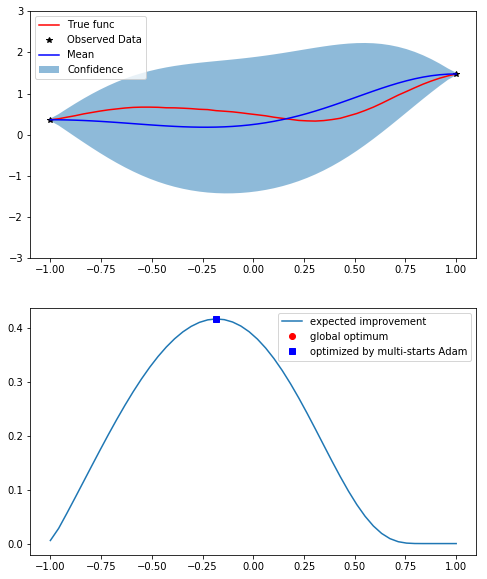

In [180]:
# test ei
y_best = torch.min(train_y)

ei = expected_improvement_wrapper(x, model, y_best)
print('max ei:', torch.max(ei))
print('optimal x:', x[torch.argmax(ei)])
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(2, 1, figsize=(8, 10))
    # Get upper and lower confidence bounds
    lower, upper = y_post.confidence_region()
    # Plot training data as black stars
    ax[0].plot(x.numpy(), y.numpy(), 'r')
    ax[0].plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax[0].plot(x.numpy(), y_post.mean.detach().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax[0].fill_between(x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax[0].set_ylim([-3, 3])
    ax[0].legend(['True func', 'Observed Data', 'Mean', 'Confidence'])
    ax[1].plot(x.numpy(), ei.detach().numpy(), label='expected improvement')
    ax[1].plot(x[torch.argmax(ei)].numpy(), torch.max(ei).numpy(), 'ro', label='global optimum')
    
num_iters = 100
learning_rate = 0.01
func = lambda x: -expected_improvement_wrapper(x, model, y_best)
bounds = np.array([[-bound, bound]])
x_star, max_ei = multi_start_optim(func, bounds=bounds, num_restarts=5)
print("optimized x:", x_star)
ax[1].plot(x_star.item(), -max_ei.item(), 'bs', label='optimized by multi-starts Adam')
ax[1].legend()

# Define q-EI using reparameterization and Monte Carlo sampling

In [171]:
# can also be defined in a class inheriting nn.Module
class qExpectedImprovement(nn.Module):
    
    def __init__(self, gp_model, y_current_best, 
                 num_mc_samples=1000, sampler='mc', seed=None):
        super(qExpectedImprovement, self).__init__()
        self.gp_model = gp_model
        self.y_current_best = y_current_best
        self.num_mc_samples = num_mc_samples
        self.z_samples = None
        self.seed = seed
        self.sampler = sampler
        
    def forward(self, x, z_samples=None, seed=None):
        """
        Args:
            x: tensor of shape (n, d)
        Returns:
            expected improvement of locations x
        """
        q = x.shape[0]
        f_preds = self.gp_model(x)
        f_mean = f_preds.mean.view(q, -1)
        f_covar = f_preds.covariance_matrix
        try:
            L = f_covar.cholesky()
        except: 
            f_covar = f_covar + torch.eye(q) * 1e-6
            L = f_covar.cholesky()
        if self.z_samples is None:  # only sample once, then reuse the samples
            if seed or self.seed is not None:
                torch.manual_seed(seed or self.seed)
            if self.sampler == 'mc':
                self.z_samples = torch.randn(q, self.num_mc_samples)
            elif self.sampler == 'qmc':
                self.z_samples = draw_sobol_normal_samples(q, self.num_mc_samples)
        y = f_mean + L @ self.z_samples
        y_min, _ = torch.min(y, 0)
        ei = torch.relu(self.y_current_best - y_min)  

        return ei.mean()
    
    def set_seed(self, seed=0):
        self.seed = seed
        self.z_sample = None
        
    def two_ei_monte_carlo(self, mu, Sigma, y_current_best, num_mc_samples):
        two_d_normal = MultivariateNormal(loc=mu.reshape(torch.Size([2])), 
                                          covariance_matrix=Sigma)
        joint_samples = two_d_normal.sample((num_mc_samples,))
        y_min, _ = torch.min(joint_samples, dim=1)
        improvement = torch.relu(y_current_best -  y_min)
        value = torch.mean(improvement)
        return value
    
    def two_ei_analytic(self, mu, Sigma, y_current_best):
        """
        qEI with q=2, analytic solution
        reference: Ginsbourger et al. (2010), Kriging Is Well-Suited to Parallelize Optimization. 
        https://pdfs.semanticscholar.org/787e/e940ff557f0dcf8d07e9c7ade39d00d5e3df.pdf
        Notations and math follow page 11-14 of the paper
        """
        
        standard_normal = Normal(loc=0, scale=1)
        normpdf = lambda x: torch.exp(standard_normal.log_prob(x))
        normcdf = lambda x: standard_normal.cdf(x)
        
        epsilon = lambda gamma1, alpha1, beta1: (
            alpha1 * 
            normpdf(torch.sqrt(beta1**2/(1+alpha1**2))) /
            torch.sqrt(1+alpha1**2)*
            normcdf(torch.sqrt(1 + alpha1**2)*
                    (gamma1 + alpha1 * beta1 / (1+alpha1**2))) 
            -
            normpdf(gamma1) *
            normcdf(alpha1*gamma1 + beta1)
        )
        
        def delta(m1, m2, sig1, sig2, c12):
            M1 = np.array([m1, m2-m1])
            Gamma = np.array(
                [[sig1**2,       c12 - sig1**2],
                 [c12 - sig1**2, sig2**2 + sig1**2 - 2*c12]]) 
            from scipy.stats import multivariate_normal as mvn
            dist = mvn(mean=M1, cov=Gamma)
            return dist.cdf(np.array([y_current_best,0.]))
        
        def B(i):
            # i=0, j=1 or i=1, j=0
            j = 1 - i
            sig1 = torch.sqrt(Sigma[i,i])  
            sig2 = torch.sqrt(Sigma[j,j])
            m1 = mu[i]
            m2 = mu[j]
            c12 = Sigma[i,j]  # covariance
            rho = c12 / (sig1 * sig2)  # correlation coefficient
            gamma1 = (y_current_best - m1) / sig1
            sqrt_one_minus_rho2 = torch.sqrt(1 - rho.pow(2))
            beta1 = (m1 - m2)/(sig2 * sqrt_one_minus_rho2)
            alpha1 = (sig1 - rho * sig2)/(sig2 * sqrt_one_minus_rho2)
            
            two_ei_value = ((m1 - y_current_best) * delta(m1, m2, sig1, sig2, c12) +
                            sig1 * epsilon(gamma1, alpha1, beta1))
            return two_ei_value
        
        def ei_plus_B(i):
            j = 1 - i
            ei = expected_improvement(mu[i], torch.sqrt(Sigma[i,i]), y_current_best)
            return ei + B(i)
        
        return ei_plus_B(0) + ei_plus_B(1)

        
    def compute_2ei_surface(self, x, analytic=True, use_forward=False, compute_diag_with_ei=True):
        num_points = x.shape[0]
        f_preds = self.gp_model(x)
        f_mean = f_preds.mean.view(num_points, -1)
        f_covar = f_preds.covariance_matrix
        two_ei_surface = np.full((num_points, num_points), fill_value=np.nan)
        
        if analytic:
            two_ei_func = lambda mu, Sigma: self.two_ei_analytic(mu, Sigma, 
                                                                 self.y_current_best)
        else:
            two_ei_func = lambda mu, Sigma: self.two_ei_monte_carlo(mu, Sigma, 
                                                                    self.y_current_best,
                                                                    self.num_mc_samples)

        for first in range(num_points):
            for second in range(first + compute_diag_with_ei, num_points):
                
                idx = [first, second]
                mu = f_mean[idx]
                Sigma = f_covar[idx][:,idx]
                try:
                    if not use_forward:
                        two_ei_surface[first, second] = two_ei_func(mu, Sigma)
                    else:
                        two_ei_surface[first, second] = self.forward(x[idx].reshape(torch.Size([2,1])))
                except:
                    warnings.warn('covariance matrix singular')
                    Sigma += torch.eye(2) * 1e-6
                    two_ei_surface[first, second] = two_ei_func(mu, Sigma)
                    
                two_ei_surface[second, first] = two_ei_surface[first, second]
            if compute_diag_with_ei:
                sig = torch.sqrt(f_covar[first, first])
                two_ei_surface[first, first] = expected_improvement(f_mean[first], 
                                                                    sig, 
                                                                    self.y_current_best)
        return two_ei_surface
    


# Plot the 2-EI surface to see if the Monte Carlo approx matches with analytic solution

tensor(0.3640)
(20, 20)
(20, 20)
(20, 20)
100000
[[0.00569242 0.07618356]
 [0.07618356 0.07315958]]
[[0.00569242 0.07591351]
 [0.07591351 0.07315958]]
[[0.00569242 0.07579889]
 [0.07579889 0.07315958]]
[0.00569242 0.07315958]
Mean absolute error: 0.00036435274458035226


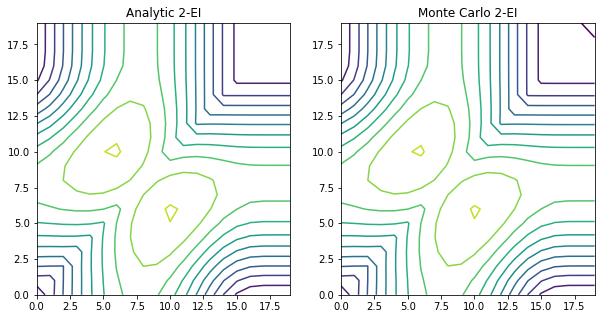

In [179]:
print(y_best)

num_mc_samples = 100000
qEI = qExpectedImprovement(model, y_best, num_mc_samples)
test_x = torch.linspace(-bound, bound, 20)
compute_diag_with_ei = True
two_ei_surface = qEI.compute_2ei_surface(test_x, analytic=False, 
                                         compute_diag_with_ei=compute_diag_with_ei)
print(two_ei_surface.shape)

two_ei_surface1 = qEI.compute_2ei_surface(test_x, analytic=True, 
                                          compute_diag_with_ei=compute_diag_with_ei)
print(two_ei_surface1.shape)

two_ei_surface2 = qEI.compute_2ei_surface(test_x, analytic=False, use_forward=True, 
                                          compute_diag_with_ei=compute_diag_with_ei)
print(two_ei_surface2.shape)


f, ax = plt.subplots(1, 2, figsize=(10, 5))
#ax[0].contour(two_ei_surface, 10)
#ax[0].title('monte carlo comput
ax[0].contour(two_ei_surface1, 10)
ax[0].set_title('Analytic 2-EI')
ax[1].contour(two_ei_surface2, 10)
ax[1].set_title('Monte Carlo 2-EI')

print(qEI.num_mc_samples)
print_num = 2
print(two_ei_surface[:print_num,:print_num])
print(two_ei_surface2[:print_num,:print_num])
print(two_ei_surface1[:print_num,:print_num])
ei_test_x = expected_improvement_wrapper(test_x, model, y_best)
print(ei_test_x[:print_num].detach().numpy())
print('Mean absolute error:', np.mean(np.abs(two_ei_surface1 - two_ei_surface2)))


# See how the error changes with the number of samples

In [105]:
exp_num = np.arange(10, 20)
num_mc_samples_to_try = 2**exp_num
len_num_mc_samples = len(num_mc_samples_to_try)
num_repeats = 5
abs_error = np.zeros((num_repeats, len_num_mc_samples, 2))
times = np.zeros((num_repeats, len_num_mc_samples, 2))
test_x = torch.linspace(-bound, bound, 20)
compute_diag_with_ei = False

for i in range(len_num_mc_samples):
    
    num_mc_samples = num_mc_samples_to_try[i]
    
    two_ei_surface1 = qEI.compute_2ei_surface(test_x, analytic=True, 
                                              compute_diag_with_ei=compute_diag_with_ei)
    for repeat in range(num_repeats):
        
        qEI = qExpectedImprovement(model, y_best, num_mc_samples, sampler='mc', seed=repeat)
        #qEI.set_seed(repeat)
        start = time.time()
        two_ei_surface2 = qEI.compute_2ei_surface(test_x, analytic=False, use_forward=True, 
                                                  compute_diag_with_ei=compute_diag_with_ei)
        end = time.time()
        times[repeat, i, 0] = end - start
        abs_error[repeat, i, 0] = np.mean(np.abs(two_ei_surface1 - two_ei_surface2))
        
        
        qEI = qExpectedImprovement(model, y_best, num_mc_samples, sampler='qmc', seed=repeat)
        #qEI.set_seed(repeat)
        start = time.time()
        two_ei_surface3 = qEI.compute_2ei_surface(test_x, analytic=False, use_forward=True, 
                                                  compute_diag_with_ei=compute_diag_with_ei)
        end = time.time()
        times[repeat, i, 1] = end - start
        abs_error[repeat, i, 1] = np.mean(np.abs(two_ei_surface1 - two_ei_surface3))
    print('Number of samples %-10d Mean absolute error: %f %f' % (num_mc_samples, 
                                                               np.mean(abs_error[:,i,0], axis=0),
                                                               np.mean(abs_error[:,i,1], axis=0)))

/home/shalijiang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:141: UserWarning: covariance matrix singular


Number of samples 1024       Mean absolute error: 0.007535 0.006067
Number of samples 2048       Mean absolute error: 0.003637 0.004352
Number of samples 4096       Mean absolute error: 0.003002 0.002929
Number of samples 8192       Mean absolute error: 0.001914 0.002058
Number of samples 16384      Mean absolute error: 0.001711 0.001495
Number of samples 32768      Mean absolute error: 0.001624 0.001044
Number of samples 65536      Mean absolute error: 0.001123 0.000732
Number of samples 131072     Mean absolute error: 0.000716 0.000515
Number of samples 262144     Mean absolute error: 0.000515 0.000369
Number of samples 524288     Mean absolute error: 0.000261 0.000274


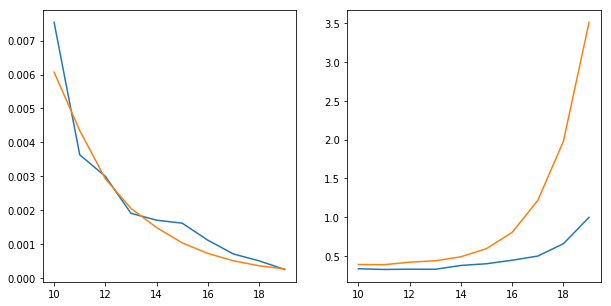

In [110]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].plot(exp_num, (abs_error.mean(axis=0)))
ax[1].plot(exp_num, times.mean(axis=0))


# Optimize 2-EI surface with optim

In [198]:
num_iters = 1000
learning_rate = 0.01
num_mc_samples = 1000
qEI = qExpectedImprovement(model, y_best, num_mc_samples)
func = lambda x: -qEI(x)
bounds = np.array([[-bound, bound],[-bound, bound]] )
x_star2, max_2ei = multi_start_optim(func, bounds=bounds, 
                               num_restarts=5, 
                               learning_rate=learning_rate, 
                               num_iters=num_iters,
                               print_every=num_iters/5)
print('true max:', two_ei_surface1.max())

Initialized at:  tensor([0.5788, 0.0371], requires_grad=True)
iter   0: EI = 0.4112008810 x.grad.norm = 0.4162659943
iter 200: EI = 0.5217529535 x.grad.norm = 0.0000204000
iter 400: EI = 0.5217528939 x.grad.norm = 0.0000000596
iter 600: EI = 0.5217528939 x.grad.norm = 0.0000000596
iter 800: EI = 0.5217528939 x.grad.norm = 0.0000000596
local optimum: tensor([ 0.0744, -0.3660], requires_grad=True)
Initialized at:  tensor([0.9507, 0.8623], requires_grad=True)
iter   0: EI = 0.0000000000 x.grad.norm = 0.0000000000
local optimum: tensor([ 0.0744, -0.3660], requires_grad=True)
Initialized at:  tensor([0.1205, 0.2614], requires_grad=True)
iter   0: EI = 0.3575929701 x.grad.norm = 0.6621972919
iter 200: EI = 0.5242694020 x.grad.norm = 0.0000234524
iter 400: EI = 0.5242694020 x.grad.norm = 0.0000001577
iter 600: EI = 0.5242694020 x.grad.norm = 0.0000001499
iter 800: EI = 0.5242694020 x.grad.norm = 0.0000000987
local optimum: tensor([-0.4212,  0.0302], requires_grad=True)
Initialized at:  tensor

tensor([-0.3684,  0.0526])
tensor([-0.1820], requires_grad=True)
optimized x: tensor([-0.1820], requires_grad=True)


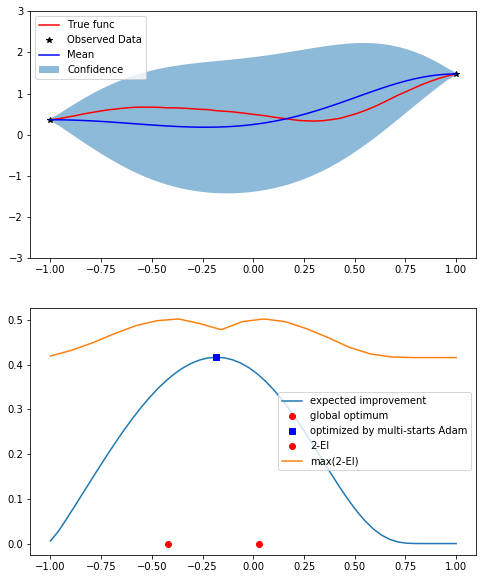

In [199]:
idx1, idx2 = np.unravel_index(np.argmax(two_ei_surface1), two_ei_surface1.shape)
print(test_x[[idx1, idx2]])
print(x_star)
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(2, 1, figsize=(8, 10))
    # Get upper and lower confidence bounds
    lower, upper = y_post.confidence_region()
    # Plot training data as black stars
    ax[0].plot(x.numpy(), y.numpy(), 'r')
    ax[0].plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax[0].plot(x.numpy(), y_post.mean.detach().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax[0].fill_between(x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax[0].set_ylim([-3, 3])
    ax[0].legend(['True func', 'Observed Data', 'Mean', 'Confidence'])
    ax[1].plot(x.numpy(), ei.detach().numpy(), label='expected improvement')
    ax[1].plot(x[torch.argmax(ei)].numpy(), torch.max(ei).numpy(), 'ro', label='global optimum')
    

print("optimized x:", x_star)
ax[1].plot(x_star.item(), -max_ei.item(), 'bs', label='optimized by multi-starts Adam')
ax[1].plot(x_star2.detach().numpy(), [0,0], 'ro', label='2-EI')
ax[1].plot(test_x.numpy(), two_ei_surface2.max(axis=0), label='max(2-EI)')
ax[1].legend()

In [200]:
num_iters = 1000
learning_rate = 0.01
num_mc_samples = 1000
qEI = qExpectedImprovement(model, y_best, num_mc_samples)
func = lambda x: -qEI(x)
bounds = np.array([[-bound, bound] for _ in range(3)] )
x_star3, max_3ei = multi_start_optim(func, bounds=bounds, 
                               num_restarts=5, 
                               learning_rate=learning_rate, 
                               num_iters=num_iters,
                               print_every=num_iters/5)
print("x star:", x_star3)
print('max ei:', max_3ei)

Initialized at:  tensor([0.6355, 0.1717, 0.8551], requires_grad=True)
iter   0: EI = 0.3210525513 x.grad.norm = 0.6634948850
iter 200: EI = 0.5156422853 x.grad.norm = 0.0000747597
iter 400: EI = 0.5156421065 x.grad.norm = 0.0000000745
iter 600: EI = 0.5156421065 x.grad.norm = 0.0000000745
iter 800: EI = 0.5156421065 x.grad.norm = 0.0000000745
local optimum: tensor([ 0.0565, -0.3824,  0.8551], requires_grad=True)
Initialized at:  tensor([0.9233, 0.7557, 0.7227], requires_grad=True)
iter   0: EI = 0.0020075219 x.grad.norm = 0.0922753289
iter 200: EI = 0.5254751444 x.grad.norm = 0.0096485373
iter 400: EI = 0.5263220668 x.grad.norm = 0.0189517848
iter 600: EI = 0.5478546023 x.grad.norm = 0.0000796423
iter 800: EI = 0.5478547215 x.grad.norm = 0.0000001908
local optimum: tensor([ 0.1740, -0.1692, -0.5063], requires_grad=True)
Initialized at:  tensor([0.2160, 0.4889, 0.1152], requires_grad=True)
iter   0: EI = 0.3448403478 x.grad.norm = 0.6154288650
iter 200: EI = 0.5429893732 x.grad.norm = 0

optimized x: tensor([-0.1820], requires_grad=True)


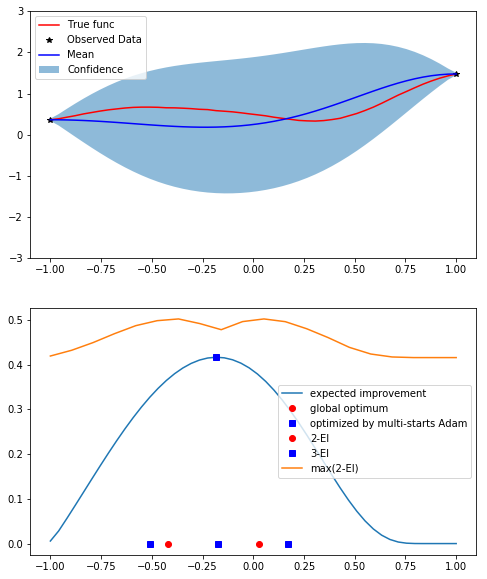

In [204]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(2, 1, figsize=(8, 10))
    # Get upper and lower confidence bounds
    lower, upper = y_post.confidence_region()
    # Plot training data as black stars
    ax[0].plot(x.numpy(), y.numpy(), 'r')
    ax[0].plot(train_x.numpy(), train_y.numpy(), 'k*')
    # Plot predictive means as blue line
    ax[0].plot(x.numpy(), y_post.mean.detach().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax[0].fill_between(x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax[0].set_ylim([-3, 3])
    ax[0].legend(['True func', 'Observed Data', 'Mean', 'Confidence'])
    ax[1].plot(x.numpy(), ei.detach().numpy(), label='expected improvement')
    ax[1].plot(x[torch.argmax(ei)].numpy(), torch.max(ei).numpy(), 'ro', label='global optimum')
    

print("optimized x:", x_star)
ax[1].plot(x_star.item(), -max_ei.item(), 'bs', label='optimized by multi-starts Adam')
ax[1].plot(x_star2.detach().numpy(), [0,0], 'ro', label='2-EI')
ax[1].plot(x_star3.detach().numpy(), [0,0,0], 'bs', label='3-EI')
ax[1].plot(test_x.numpy(), two_ei_surface2.max(axis=0), label='max(2-EI)')
ax[1].legend()